In [38]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import argparse
import json
import config


from generator import Generator
from discriminator import Discriminator
from landcover_model import LandcoverModel
from dataset import SatelliteDataset
from deterministic_dataset import DeterministicSatelliteDataset
from utils import save_example, calc_all_IoUs, StyleLoss, calc_accuracy
import config
from plot_losses import plot_losses, plot_ious
from augmentations import apply_augmentations

from datautils import unprocess, create_img_from_classes
import numpy as np
import matplotlib.pyplot as plt

In [39]:
save_ext = "png"
device = "cpu"
results_dir = "results/run34"
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(torch.load(f"{results_dir}/models/generator.pt"))
discriminator.load_state_dict(torch.load(f"{results_dir}/models/discriminator.pt"))

<All keys matched successfully>

In [40]:
landcover_model = LandcoverModel().to(device)
landcover_model.load_state_dict(torch.load("../landcover_model/models/lc_model.pt"))
vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])

Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [58]:
ds = DeterministicSatelliteDataset("../../data/grid_dir/val")
loader = DataLoader(ds, 1, shuffle=False)

In [59]:
smooth_l1_beta = 0.1
pixel_loss_fn = nn.SmoothL1Loss(beta=smooth_l1_beta)
adv_loss_fn = nn.MSELoss()
style_loss_fn = StyleLoss(relu3_3, device)
# Don't use weighted class loss, since we don't have an unbalaced training set, just that the classes are unbalaced
# but they have a similar balance in the validation set.
class_loss_fn = nn.CrossEntropyLoss()

feature_loss_fn = nn.SmoothL1Loss(beta=smooth_l1_beta)

In [82]:
def myreshape(arrays):
    for i in range(len(arrays)):
        arrays[i] = arrays[i].reshape((1, arrays[i].shape[0], arrays[i].shape[1], arrays[i].shape[2]))
        arrays[i] = arrays[i].to(device)
    return arrays

In [108]:

rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab, masked_areas = ds.__getitem__(231)

masked_areas = np.array(masked_areas)

[rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab] = myreshape([rgb_a, rgb_ab, lc_a, lc_b, binary_mask, lc_ab])

masked_areas = masked_areas.reshape((masked_areas.shape[0], masked_areas.shape[1], 1))
## DISCRIMINATOR TRAIN


generator.eval()
discriminator.eval()
for m in generator.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.train()


flag_setting = torch.cuda.amp.autocast() and torch.no_grad()

with flag_setting:
    fake_img = generator(rgb_a, lc_ab, binary_mask)
    fake_img_aug, _ = apply_augmentations(fake_img, None, types=['blit', 'noise'])

    _, d_patchGAN_fake = discriminator(fake_img_aug)
    # use sigmoid ?
    # maybe use random image as rgb_a
    rgb_a_aug, lc_a_aug = apply_augmentations(rgb_a, lc_a, types=['blit', 'noise'])
    gen_lc_a, d_patchGAN_real = discriminator(rgb_a_aug)


    # is this the correct use of adv loss? PatchGAN https://github.com/znxlwm/pytorch-pix2pix/blob/3059f2af53324e77089bbcfc31279f01a38c40b8/pytorch_pix2pix.py 
    # uses BCE_Loss
    # LSGAN https://arxiv.org/abs/1611.04076 uses mse but no patches
    #
    # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/cycle_gan_model.py
    # In this they say they use PatchGAN, they do it like this and dont use sigmoid in discriminator
    # and either use MSE or BCEWithLogits, and they do wgangp: see line 270 in https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
    d_fake_loss = adv_loss_fn(d_patchGAN_fake, torch.zeros_like(d_patchGAN_fake))
    d_real_loss = adv_loss_fn(d_patchGAN_real, torch.ones_like(d_patchGAN_real))


    d_lc_real_loss = class_loss_fn(gen_lc_a, torch.argmax(lc_a_aug, 1))
    d_loss = (d_fake_loss + d_real_loss + d_lc_real_loss) / 2



## GENERATOR Losses


with flag_setting:
    fake_img = generator(rgb_a, lc_ab, binary_mask)
    fake_img_aug, _ = apply_augmentations(fake_img, None, types=['blit', 'noise'])
    _, g_patchGAN = discriminator(fake_img_aug)
    # Use landcover model for lc_gen_fake?
    lc_gen_fake = landcover_model(fake_img)
    # lc_gen_fake = torch.softmax(lc_gen_fake, dim=1)

    g_adv_loss = adv_loss_fn(g_patchGAN, torch.ones_like(g_patchGAN))


    g_gen_lc_loss = class_loss_fn(lc_gen_fake, torch.argmax(lc_ab, 1))



    id_img = generator(rgb_a, lc_a, torch.zeros_like(binary_mask).to(device))
    g_pixel_id_loss = pixel_loss_fn(id_img, rgb_a)
    feature_id_img = relu3_3(id_img)
    feature_rgb_a = relu3_3(rgb_a)
    g_feature_id_loss = feature_loss_fn(feature_id_img, feature_rgb_a)

    local_g_style_loss = 0
    local_g_pixel_loss = 0
    local_g_feature_loss = 0

    # set changed places to 0 
    fake_img_unchanged_area = fake_img.clone()
    rgb_a_unchanged_area = rgb_a.clone()

    fake_img_changed_area = torch.zeros_like(fake_img_unchanged_area)
    rgb_a_changed_area = torch.zeros_like(rgb_a)
    rgb_ab_changed_area = torch.zeros_like(rgb_ab)

    # look individually at changed area and do a pixel loss
    # Not sure what type of loss is best,
    # Maybe using some kind of local discriminator would be better, like in local and global inpainting paper
    for j in range(len(masked_areas[0][0])):
        for i in range(len(masked_areas)):

            r_w = masked_areas[i][0][j]
            r_h = masked_areas[i][1][j]
            mask_size_w = masked_areas[i][2][j]
            mask_size_h = masked_areas[i][3][j]

            #r_w, r_h, mask_size_w, mask_size_h = masked_area
            # maybe not use the rgb_a is the classes are the same.
            # the boarder margin is only constrained by the adversarial loss...
            gen_local_area = fake_img[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]
            # new area
            rgb_ab_local_area = rgb_ab[j,:,r_w-config.local_area_margin:r_w + mask_size_w + config.local_area_margin, r_h - config.local_area_margin:r_h+mask_size_h + config.local_area_margin]
            # old area
            rgb_a_local_area = rgb_a[j,:,r_w-config.local_area_margin:r_w + mask_size_w + config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]


            # Style loss
            local_g_style_loss += style_loss_fn(gen_local_area, rgb_ab_local_area)

            # Pixel loss
            local_g_pixel_loss += pixel_loss_fn(gen_local_area, rgb_ab_local_area)

            # Feature loss
            c, w, h = gen_local_area.shape
            gen_local_feature = relu3_3(gen_local_area.reshape(1, c, w, h))
            rgb_ab_local_feature = relu3_3(rgb_ab_local_area.reshape(1, c, w, h))  
            local_g_feature_loss += feature_loss_fn(gen_local_feature, rgb_ab_local_feature)

            fake_img_changed_area[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin] = fake_img[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]
            rgb_a_changed_area[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin] = rgb_a[j,:,r_w-config.local_area_margin:r_w + mask_size_w + config.local_area_margin, r_h - config.local_area_margin:r_h+mask_size_h + config.local_area_margin]
            rgb_ab_changed_area[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin] = rgb_ab[j,:,r_w-config.local_area_margin:r_w + mask_size_w + config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin]

            # fake_img_unchanged_area[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin] = torch.zeros(3, mask_size_w + (config.local_area_margin * 2), mask_size_h + (config.local_area_margin * 2))
            # rgb_a_unchanged_area[j,:,r_w-config.local_area_margin:r_w + mask_size_w+config.local_area_margin, r_h-config.local_area_margin:r_h+mask_size_h+config.local_area_margin] = torch.zeros(3, mask_size_w + (config.local_area_margin * 2), mask_size_h + (config.local_area_margin * 2))
            fake_img_unchanged_area[j,:,r_w:r_w + mask_size_w, r_h:r_h+mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)
            rgb_a_unchanged_area[j,:,r_w:r_w + mask_size_w, r_h:r_h+mask_size_h] = torch.zeros(3, mask_size_w, mask_size_h)


    g_pixel_loss = pixel_loss_fn(fake_img_unchanged_area, rgb_a_unchanged_area)


    fake_img_feature = relu3_3(fake_img_unchanged_area)
    rgb_a_feature = relu3_3(rgb_a_unchanged_area)                    
    g_feature_loss = feature_loss_fn(fake_img_feature, rgb_a_feature)

    local_g_pixel_loss = local_g_pixel_loss / (len(masked_areas[0][0]) * config.num_inpaints)
    local_g_style_loss = local_g_style_loss / (len(masked_areas[0][0]) * config.num_inpaints)
    local_g_feature_loss = local_g_feature_loss / (len(masked_areas[0][0]) * config.num_inpaints)


In [109]:
g_pixel_loss

tensor(0.0067)

In [110]:
def unprocess_lc(lc):
    return create_img_from_classes(unprocess(lc))

In [111]:
save_folder = "losses_imgs"
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

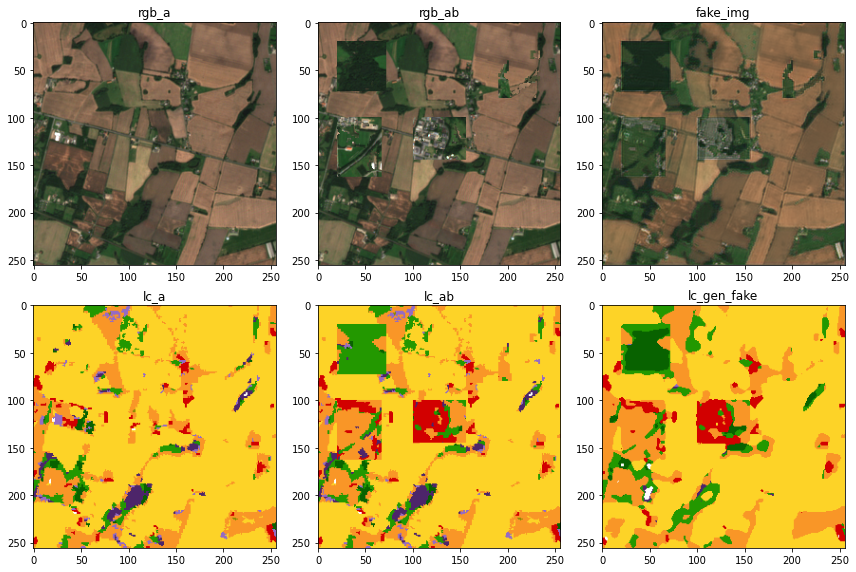

In [112]:
fig,ax = plt.subplots(2,3, figsize=(12, 8))
fig.tight_layout()
ax[0,0].imshow(unprocess(rgb_a))
ax[0,0].set_title("rgb_a")

ax[0,1].imshow(unprocess(rgb_ab))
ax[0,1].set_title("rgb_ab")

ax[0,2].imshow(unprocess(fake_img))
ax[0,2].set_title("fake_img")

ax[1,0].imshow(unprocess_lc(lc_a))
ax[1,0].set_title("lc_a")

ax[1,1].imshow(unprocess_lc(lc_ab))
ax[1,1].set_title("lc_ab")

ax[1,2].imshow(unprocess_lc(lc_gen_fake))
ax[1,2].set_title("lc_gen_fake")
plt.savefig(os.path.join(save_folder, f"g_all.{save_ext}"))

In [113]:
plt.imsave(os.path.join(save_folder, f"rgb_a.{save_ext}"), unprocess(rgb_a))

plt.imsave(os.path.join(save_folder, f"rgb_ab.{save_ext}"), unprocess(rgb_ab))

plt.imsave(os.path.join(save_folder, f"fake_img.{save_ext}"), unprocess(fake_img))

plt.imsave(os.path.join(save_folder, f"lc_a.{save_ext}"), unprocess_lc(lc_a))

plt.imsave(os.path.join(save_folder, f"lc_ab.{save_ext}"), unprocess_lc(lc_ab))

plt.imsave(os.path.join(save_folder, f"lc_gen_fake.{save_ext}"), unprocess_lc(lc_gen_fake))

#plt.imshow(binary_mask[0][0].cpu())
plt.imsave(os.path.join(save_folder, f"binary_mask.{save_ext}"), binary_mask[0][0].cpu())


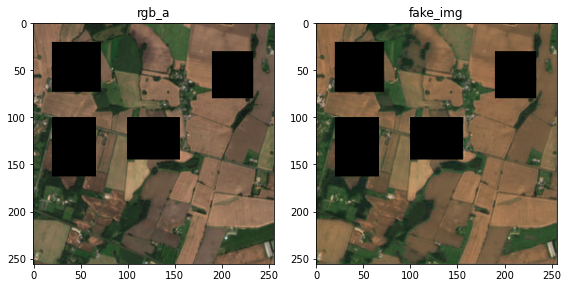

In [114]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout()
ax[0].imshow(unprocess(rgb_a_unchanged_area))
ax[0].set_title("rgb_a")

ax[1].imshow(unprocess(fake_img_unchanged_area))
ax[1].set_title("fake_img")
plt.savefig(os.path.join(save_folder, f"unchange_areas.{save_ext}"))

plt.imsave(os.path.join(save_folder, f"fake_img_unchanged_area.{save_ext}"), unprocess(fake_img_unchanged_area))
plt.imsave(os.path.join(save_folder, f"rgb_a_unchanged_area.{save_ext}"), unprocess(rgb_a_unchanged_area))

### Local changes

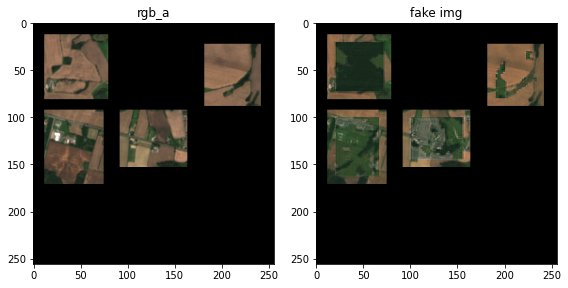

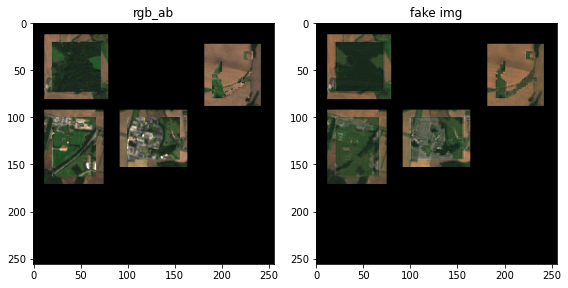

In [115]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig.tight_layout()
ax[0].imshow(unprocess(rgb_a_changed_area))
ax[0].set_title("rgb_a")

ax[1].imshow(unprocess(fake_img_changed_area))
ax[1].set_title("fake img")

plt.savefig(os.path.join(save_folder, f"local_rgb_a_vs_fake_img.{save_ext}"))

fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig.tight_layout()
ax[0].imshow(unprocess(rgb_ab_changed_area))
ax[0].set_title("rgb_ab")

ax[1].imshow(unprocess(fake_img_changed_area))
ax[1].set_title("fake img")

plt.savefig(os.path.join(save_folder, f"local_rgb_ab_vs_fake_img.{save_ext}"))

plt.imsave(os.path.join(save_folder, f"local_rgb_a.{save_ext}"), unprocess(rgb_a_changed_area))
plt.imsave(os.path.join(save_folder, f"local_rgb_ab.{save_ext}"), unprocess(rgb_ab_changed_area))
plt.imsave(os.path.join(save_folder, f"local_fake_img.{save_ext}"), unprocess(fake_img_changed_area))

### g_gen_lc_loss

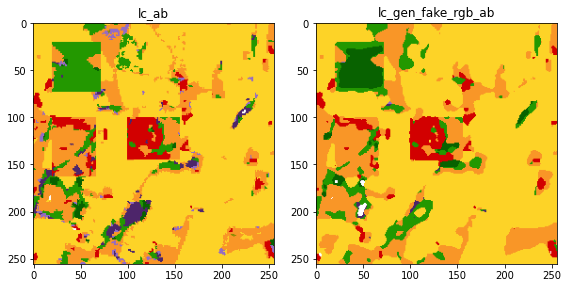

In [116]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout()
ax[0].imshow(unprocess_lc(lc_ab))
ax[0].set_title("lc_ab")
ax[1].imshow(unprocess_lc(lc_gen_fake))
ax[1].set_title("lc_gen_fake_rgb_ab")
plt.savefig(os.path.join(save_folder, f"g_gen_lc_loss.{save_ext}"))

In [117]:
g_gen_lc_loss

tensor(0.3802)

In [118]:
gen_lc_rgb_ab = landcover_model(rgb_ab)
gen_lc_rgb_a = landcover_model(rgb_a)

In [119]:
class_loss_fn(lc_gen_fake, torch.argmax(gen_lc_rgb_ab, 1))

tensor(0.5200)

Text(0.5, 1.0, 'gen_lc_rgb_a')

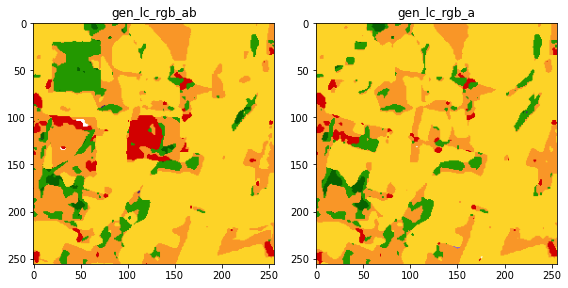

In [120]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig.tight_layout()
ax[0].imshow(unprocess_lc(gen_lc_rgb_ab.detach()))
ax[0].set_title("gen_lc_rgb_ab")

ax[1].imshow(unprocess_lc(gen_lc_rgb_a.detach()))
ax[1].set_title("gen_lc_rgb_a")

In [121]:
class_loss_fn(gen_lc_rgb_a, torch.argmax(lc_a, 1))

tensor(0.5699, grad_fn=<NllLoss2DBackward>)

### Discriminator losses

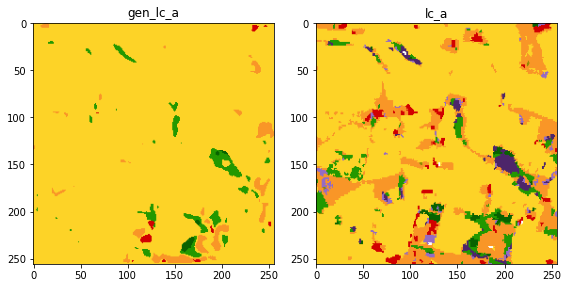

In [122]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig.tight_layout()
ax[0].imshow(unprocess_lc(gen_lc_a))
ax[0].set_title("gen_lc_a")

ax[1].imshow(unprocess_lc(lc_a_aug))
ax[1].set_title("lc_a")
plt.savefig(os.path.join(save_folder, f"d_lc_loss.{save_ext}"))

In [123]:
class_loss_fn(gen_lc_a, torch.argmax(lc_a_aug, 1))

tensor(0.5889)